In [1]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , \
    Median_w_Error_95,Gen_grid, Iterative_stacking, Gauss_dist
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

# UVJ plot

In [36]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
# uvjSDB = pd.read_pickle('../data/select_samp.pkl')

In [34]:
restc_s=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

In [32]:
IDS=[]
IDN=[]

for i in galDB.index:
    if galDB.gids[i][0]== 's':
        IDS.append(int(galDB.gids[i][1:]) - 1)
        
    if galDB.gids[i][0]== 'n':
        IDN.append(int(galDB.gids[i][1:]) - 1)

In [35]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


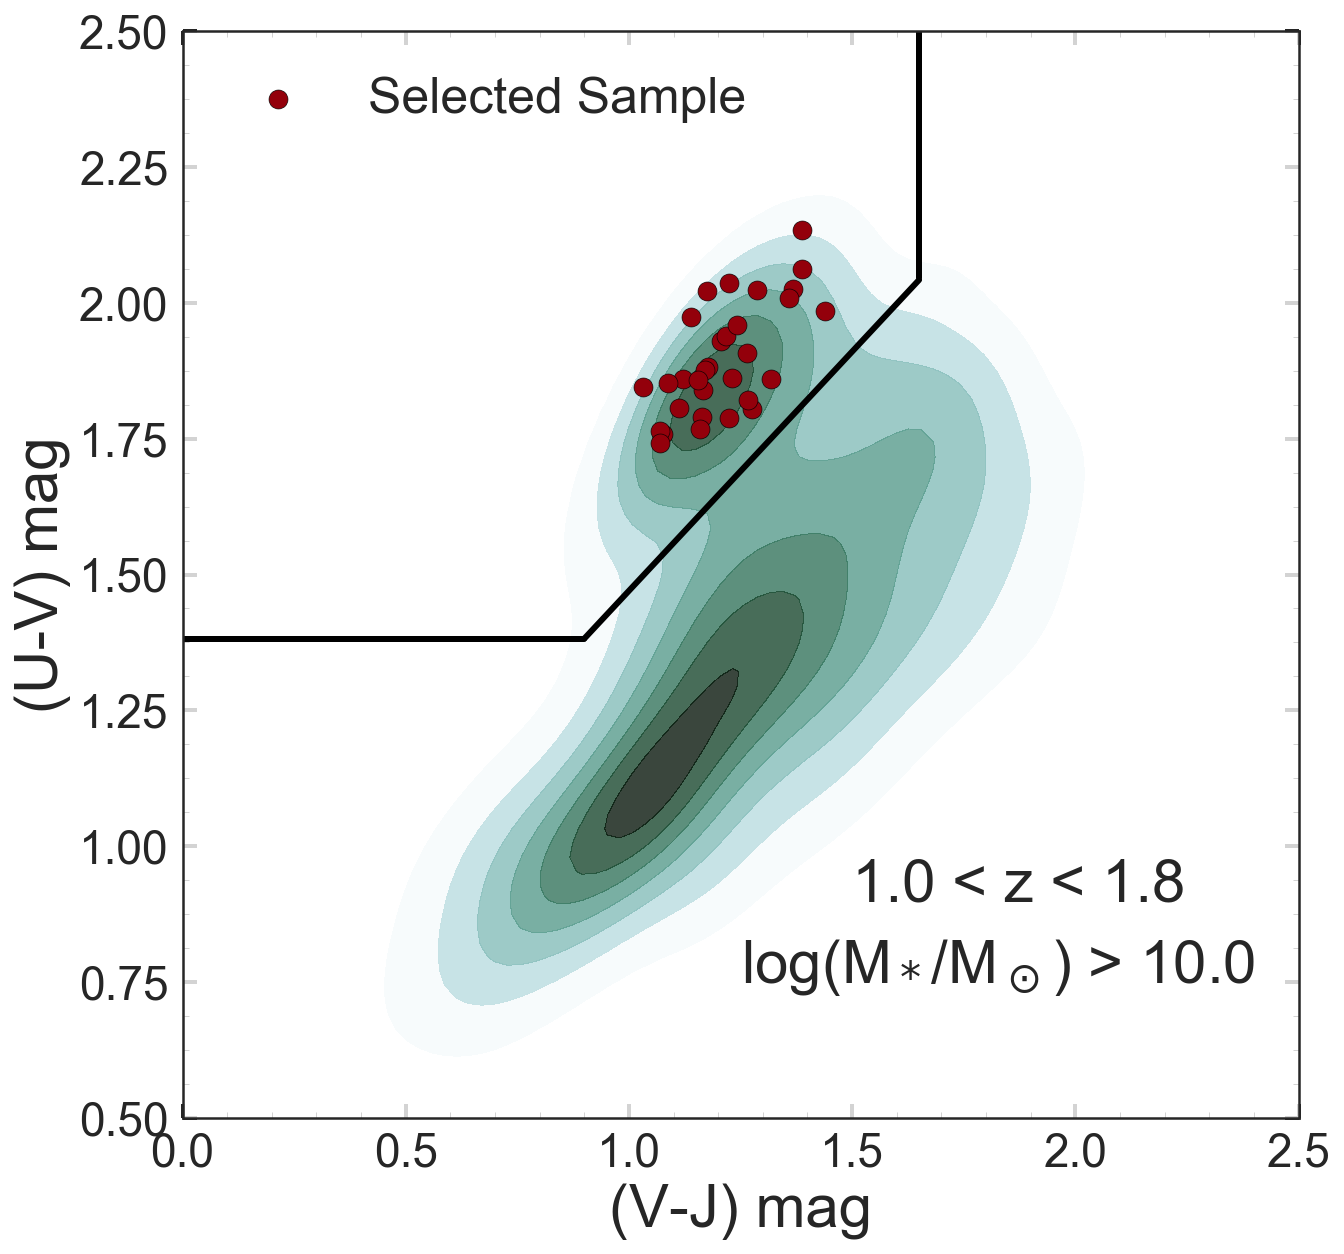

In [37]:
###PLOTS
%matplotlib inline

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
# plt.scatter(vjS,uvS,facecolor='none',
#             edgecolors='k',linewidth=2, label = 'Rejected Sample')
plt.scatter(vjS,uvS,edgecolors='k',color='#93000B',s=90, label = 'Selected Sample')
plt.scatter(vjN,uvN,edgecolors='k',color='#93000B',s=90)

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=25)
plt.text(1.5,0.90,'1.0 < z < 1.8', fontsize = 30)
plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
# plt.savefig('../plots/uvj_kde_plot_5-16.pdf',bbox_inches = 'tight')

# Age vs Redshift

In [4]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/{0}_full_fit_{1}_pos.npy'.format(DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [13]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

# gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')
ferrdb = pd.read_pickle('../data/Q_ferreras.pkl')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl,Px = Iterative_stacking(Pl_grid,age)
Pm,Px = Iterative_stacking(Pm_grid,age)
Ph,Px = Iterative_stacking(Ph_grid,age)
Puh,Px = Iterative_stacking(Puh_grid,age)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

lt=np.array(lzDB['tx'])
mt=np.array(mzDB['tx'])
ht=np.array(hzDB['tx'])
uht=np.array(uhzDB['tx'])
# gmtlt=np.array(gmtlDB['tx'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in add


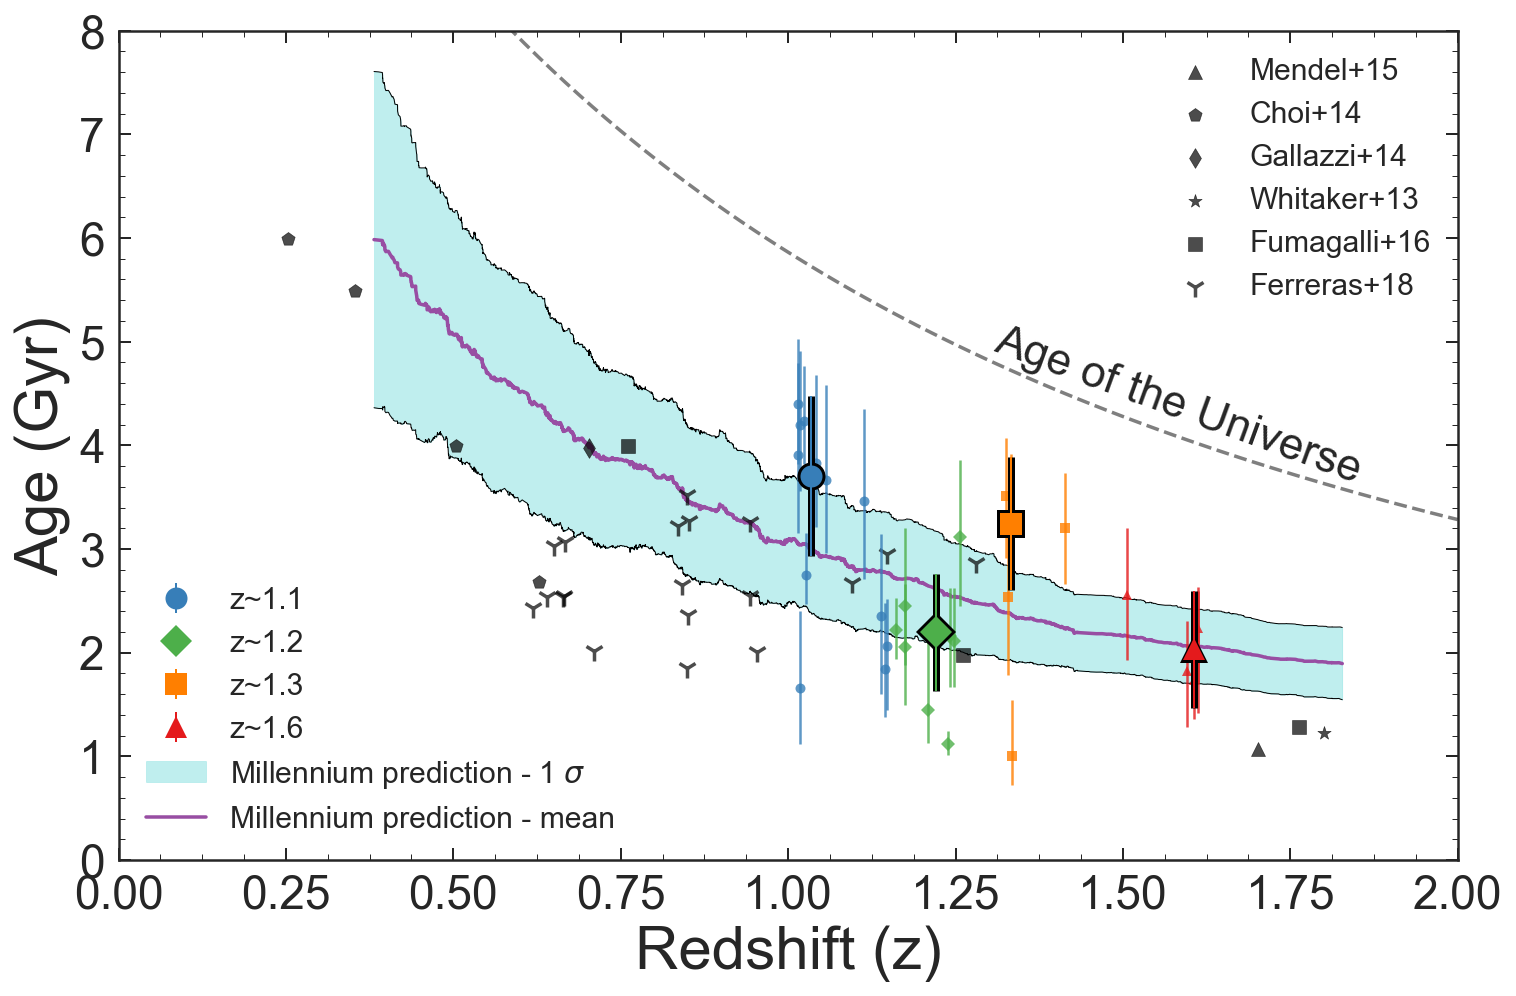

In [19]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^',zorder=2,alpha=0.7)         
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p',zorder=2,alpha=0.7) 
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d',zorder=2,alpha=0.7)       
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*',zorder=2,alpha=0.7)       
ax5=plt.scatter(fumx[6:9],fumy[6:9],color='k',zorder=2,marker='s',alpha=0.7)
ax6=plt.scatter(ferrdb['z'],ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,alpha=0.7)

###allpoints
plt.errorbar(lzDB['z_grism'],lt,yerr=[lzDB['tx_l'],lzDB['tx_h']],
             color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o',zorder=3)
plt.errorbar(mzDB['z_grism'],mt,yerr=[mzDB['tx_l'],mzDB['tx_h']],
             color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D',zorder=3)
plt.errorbar(hzDB['z_grism'],ht,yerr=[hzDB['tx_l'],hzDB['tx_h']],
             color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s',zorder=3)
plt.errorbar(uhzDB['z_grism'],uht,yerr=[uhzDB['tx_l'],uhzDB['tx_h']],
             color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^',zorder=3)

####edge
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color='k',elinewidth=3.5,ms=14,fmt='o',zorder=4)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='k',elinewidth=3.5,ms=14,fmt='D',zorder=4)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='k',elinewidth=3.5,ms=14,fmt='s',zorder=4)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=3.5,ms=14,fmt='^',zorder=4)

####face
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color ='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1',zorder=5)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2',zorder=5)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3',zorder=5)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6',zorder=5)

#### millenium
plt.plot(z_g[IDW],rmean,color = '#984ea3',zorder=1,label = 'Millennium prediction - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5,zorder=1)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5,zorder=1)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium prediction - 1 $\sigma$',zorder=1)

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([2,3,4,5,1,0])

plt.axis([0.,2.0,0,8])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5,ax6],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16','Ferreras+18'],
              fontsize=15)
plt.legend(handles[IDX], labels[IDX],loc = 3, fontsize=15)
currentAxis.add_artist(l1)
# plt.savefig('../plots/agevz_featgroup_all_dt_2-27.pdf',bbox_inches = 'tight')




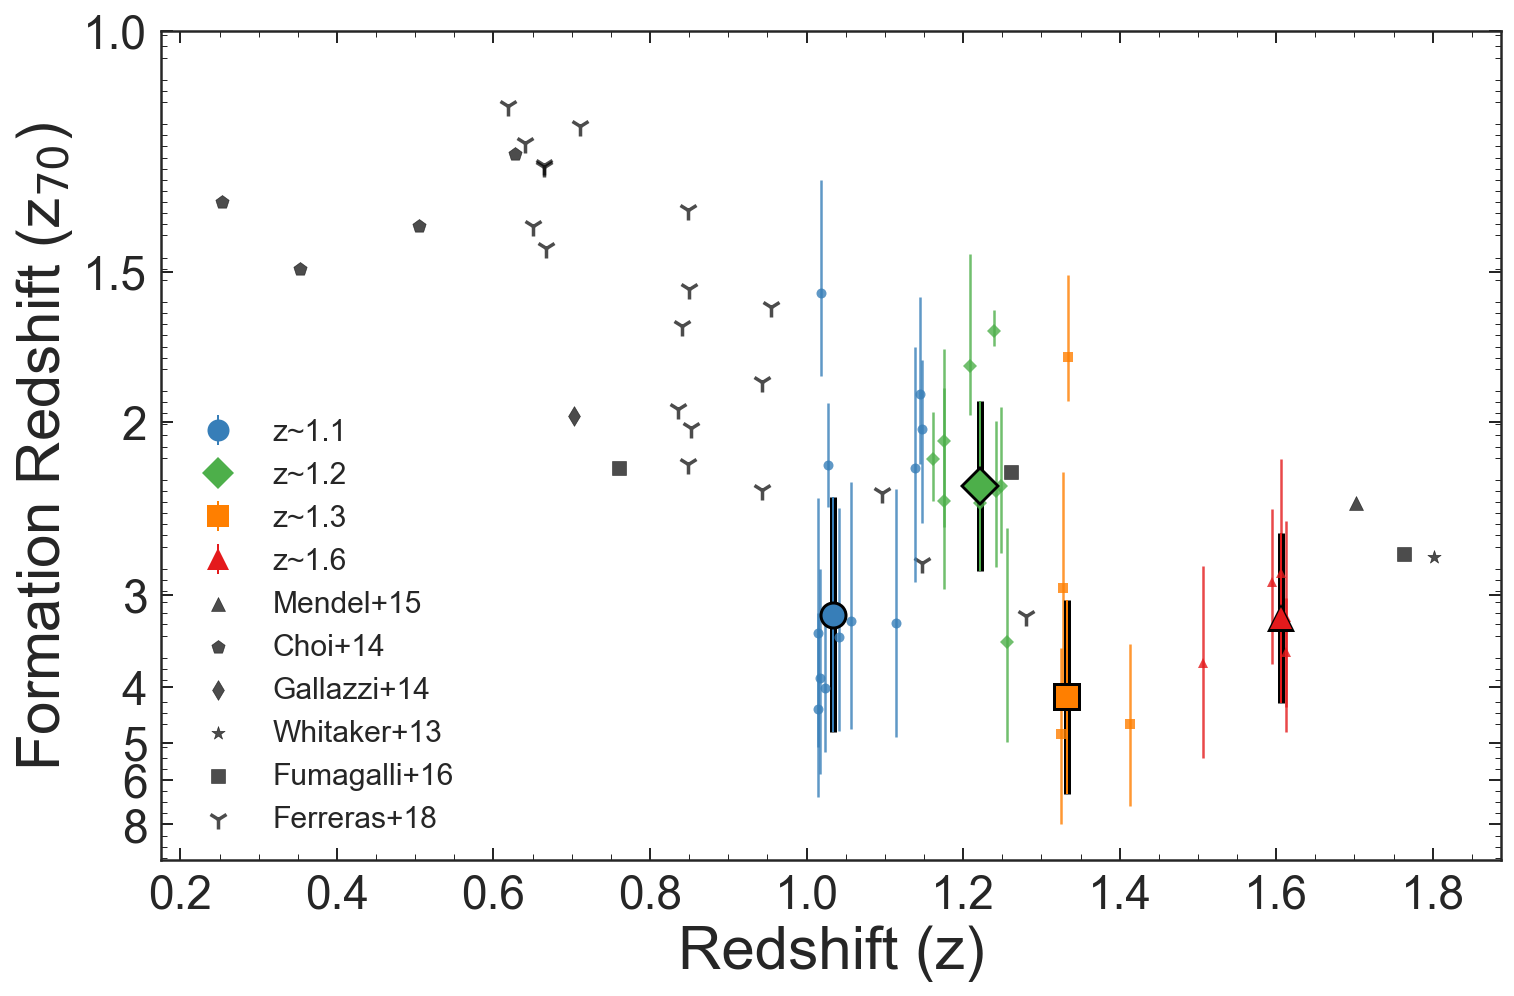

In [22]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

plt.scatter(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],color = 'k',marker='^',label='Mendel+15',alpha=0.7)
plt.scatter(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],color = 'k',marker='p',label='Choi+14',alpha=0.7)
plt.scatter(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],color = 'k',marker='d',label='Gallazzi+14',alpha=0.7)
plt.scatter(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],color = 'k',marker='*',label='Whitaker+13',alpha=0.7)
plt.scatter(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],color='k',zorder=2,marker='s',label='Fumagalli+16',alpha=0.7)
plt.scatter(ferrdb['z'],Oldest_galaxy(ferrdb['z'].values) - ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,label='Ferreras+18',alpha=0.7)

plt.errorbar(lzDB['z_grism'], Oldest_galaxy(lzDB['z_grism']) - lt,
             yerr=[lzDB['tx_l'],lzDB['tx_h']],color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['z_grism'],Oldest_galaxy(mzDB['z_grism']) - mt,
             yerr=[mzDB['tx_l'],mzDB['tx_h']],color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['z_grism'],Oldest_galaxy(hzDB['z_grism']) - ht,
             yerr=[hzDB['tx_l'],hzDB['tx_h']],color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['z_grism'],Oldest_galaxy(uhzDB['z_grism']) - uht,
             yerr=[uhzDB['tx_l'],uhzDB['tx_h']],color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^')

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='k',fmt='o',elinewidth=3.5,ms=14)
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='k',fmt='D',elinewidth=3.5,ms=14)
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='k',fmt='s',elinewidth=3.5,ms=14)
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',fmt='^',elinewidth=3.5,ms=14)

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# currentAxis.add_patch(Rectangle((np.median(lzDB['hi_res_specz'])-0.05, 
#                                  Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed)
#                                 ,0.1,lmed-lmed_d,fill=False ,edgecolor='k', zorder=2,
#                                 label='Dust Bound',linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(mzDB['hi_res_specz'])-0.05, 
#                                  Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed)
#                                 ,0.1,mmed-mmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(hzDB['hi_res_specz'])-0.05,
#                                  Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed)
#                                 ,0.1,hmed-hmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(uhzDB['hi_res_specz'])-0.05,
#                                  Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed)
#                                 ,0.1,uhmed-uhmed_d,fill=False ,edgecolor='k', zorder=2,linewidth=2,linestyle='dashed'))

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([6,7,8,9,0,1,2,3,4,5])

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
# plt.savefig('../plots/agevz_rshift_all_dt_2-27.pdf',bbox_inches = 'tight')

# Mass Metallicity

In [25]:
"""DATA"""
gmtlDB = galDB

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl,Px = Iterative_stacking(Pl_grid,metal)
Pm,Px = Iterative_stacking(Pm_grid,metal)
Ph,Px = Iterative_stacking(Ph_grid,metal)
Puh,Px = Iterative_stacking(Puh_grid,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx'])
mZ=np.array(mzDB['Zx'])
hZ=np.array(hzDB['Zx'])
uhZ=np.array(uhzDB['Zx'])
gmtlZ=np.array(gmtlDB['Zx'])

lerrs = gmtlDB['Zx_l']/(gmtlDB['Zx'] * np.log(10))
herrs = gmtlDB['Zx_h']/(gmtlDB['Zx'] * np.log(10))
errs = ((gmtlDB['Zx_l'] + gmtlDB['Zx_h'])/2) / (gmtlDB['Zx'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs,cov = Linear_fit(gmtlDB['l_mass'],np.log10(gmtlZ/0.019),errs,samp,return_cov=True)

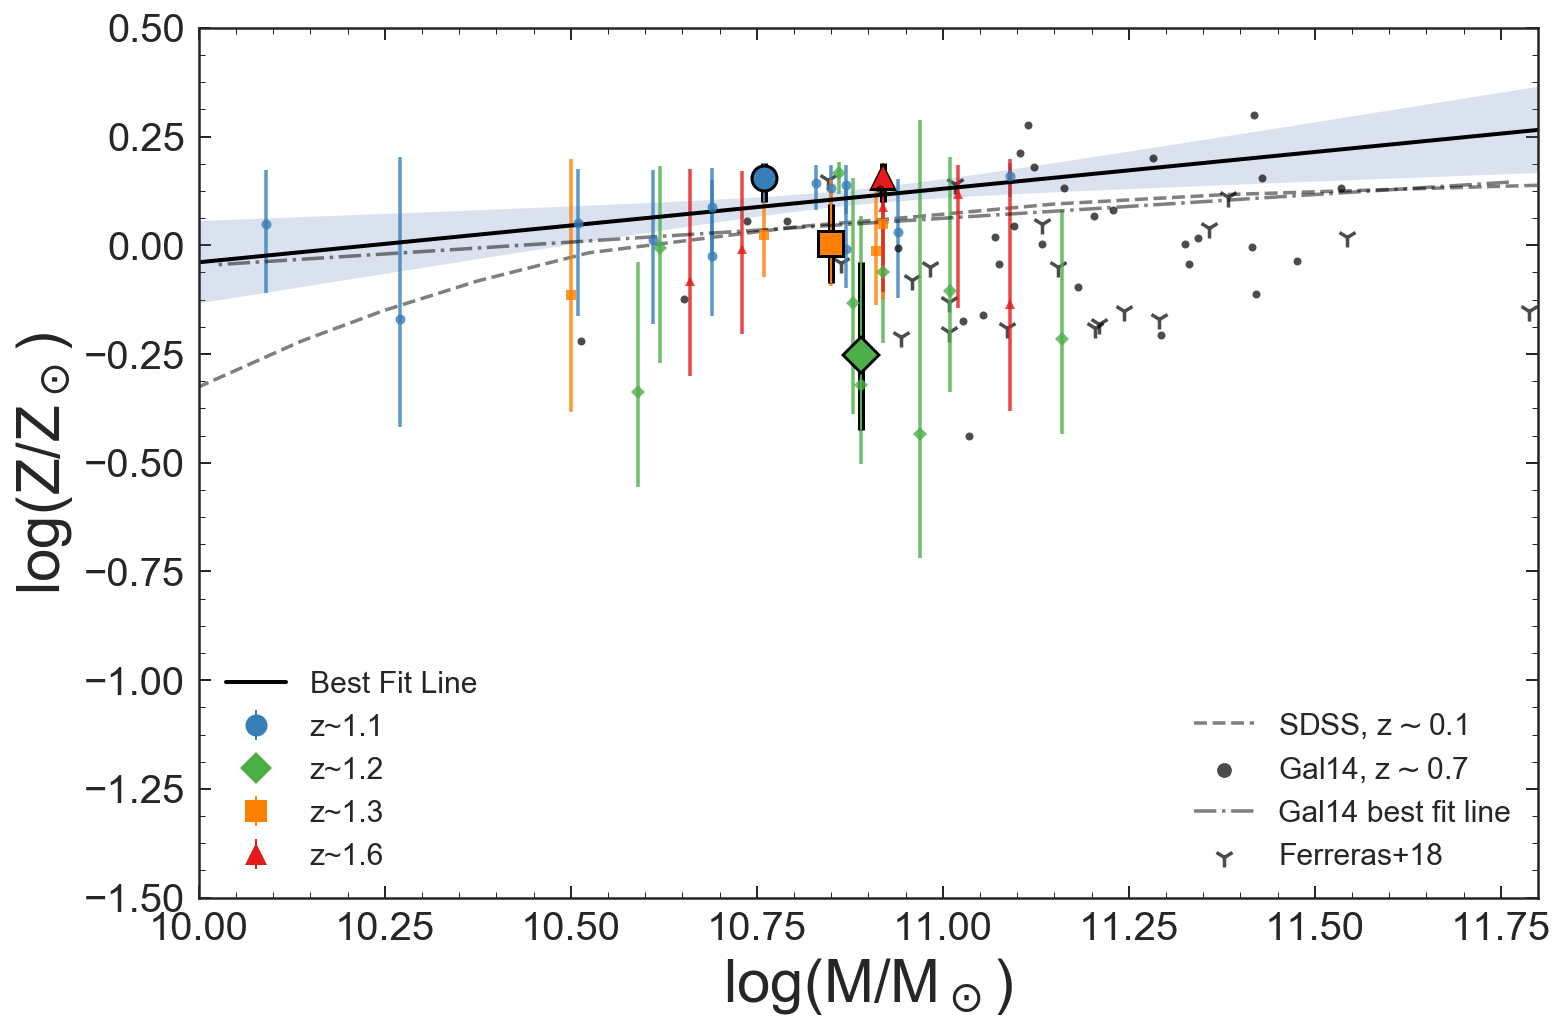

In [30]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.5,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.7,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.7)#,label='Gallazzi+14,z=0.7')
#####ferreras points
ferra = plt.scatter(np.log10(ferrdb['M']*1E11),ferrdb['Z/H'].values,color='k',zorder=2,marker='1',alpha=.7,s=100,label='Ferreras+18')
legend1 = plt.legend([sdss,galpts,galbf,ferra],
                     ['SDSS, z$\sim$0.1','Gal14, z$\sim$0.7','Gal14 best fit line','Ferreras+18'],
                     loc = 4,fontsize=15)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['l_mass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_l']/(lzDB['Zx'] * np.log(10)),
            lzDB['Zx_h']/(lzDB['Zx'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['l_mass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_l']/(mzDB['Zx'] * np.log(10)),
            mzDB['Zx_h']/(mzDB['Zx'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['l_mass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_l']/(hzDB['Zx'] * np.log(10)),
            hzDB['Zx_h']/(hzDB['Zx'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['l_mass'],np.log10(uhZ/0.019), yerr=[uhzDB['Zx_l']/(uhzDB['Zx'] * np.log(10)),
            uhzDB['Zx_h']/(uhzDB['Zx'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^')

### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


#### edge
plt.errorbar(np.median(lzDB['l_mass']),np.log10(lmed/0.019), 
             yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],color='k',ms=14,fmt='o',elinewidth=3.5)
plt.errorbar(np.median(mzDB['l_mass']),np.log10(mmed/0.019),  
             yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],color='k',ms=14,fmt='D',elinewidth=3.5)
plt.errorbar(np.median(hzDB['l_mass']),np.log10(hmed/0.019),  
             yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],color='k',ms=14,fmt='s',elinewidth=3.5)
plt.errorbar(np.median(uhzDB['l_mass']),np.log10(uhmed/0.019),  
             yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],color='k',ms=14,fmt='^',elinewidth=3.5)
#### face
plt.errorbar(np.median(lzDB['l_mass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['l_mass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['l_mass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['l_mass']),np.log10(uhmed/0.019),  yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# plt.plot(samp,0.1616*samp11 + 0.0867,'r')

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([0,3,4,5,6])

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
currentAxis.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
# plt.minorticks_on()

plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
# plt.savefig('../plots/metalmass_featgroup_6-8.pdf',bbox_inches = 'tight')

# Stacks

In [13]:
"""DATA"""

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PDl_grid = Gen_grid(lzDB,'d')
PDm_grid = Gen_grid(mzDB,'d')
PDh_grid = Gen_grid(hzDB,'d')
PDuh_grid = Gen_grid(uhzDB,'d')

PZl,PZx = Iterative_stacking(PZl_grid,metal)
PZm,PZx = Iterative_stacking(PZm_grid,metal)
PZh,PZx = Iterative_stacking(PZh_grid,metal)
PZuh,PZx = Iterative_stacking(PZuh_grid,metal)

PTl,Ptx = Iterative_stacking(PTl_grid,age)
PTm,Ptx = Iterative_stacking(PTm_grid,age)
PTh,Ptx = Iterative_stacking(PTh_grid,age)
PTuh,Ptx = Iterative_stacking(PTuh_grid,age)

PDl,PDx = Iterative_stacking(PDl_grid,dust)
PDm,PDx = Iterative_stacking(PDm_grid,dust)
PDh,PDx = Iterative_stacking(PDh_grid,dust)
PDuh,PDx = Iterative_stacking(PDuh_grid,dust)

wPZl = Stack_posteriors(PZl_grid,metal)
wPZm = Stack_posteriors(PZm_grid,metal)
wPZh = Stack_posteriors(PZh_grid,metal)
wPZuh = Stack_posteriors(PZuh_grid,metal)

wPTl = Stack_posteriors(PTl_grid,age)
wPTm = Stack_posteriors(PTm_grid,age)
wPTh = Stack_posteriors(PTh_grid,age)
wPTuh = Stack_posteriors(PTuh_grid,age)

Zmedl, Zler, Zher = np.round(Median_w_Error(PZl,PZx),3)
Zmedm, Zler, Zher = np.round(Median_w_Error(PZm,PZx),3)
Zmedh, Zler, Zher = np.round(Median_w_Error(PZh,PZx),3)
Zmeduh, Zler, Zher = np.round(Median_w_Error(PZuh,PZx),3)
tmedl, tler, ther = np.round(Median_w_Error(PTl,Ptx),1)
tmedm, tler, ther = np.round(Median_w_Error(PTm,Ptx),1)
tmedh, tler, ther = np.round(Median_w_Error(PTh,Ptx),1)
tmeduh, tler, ther = np.round(Median_w_Error(PTuh,Ptx),1)
dmedl, dler, dher = np.round(Median_w_Error(PDl,PDx),1)
dmedm, dler, dher = np.round(Median_w_Error(PDm,PDx),1)
dmedh, dler, dher = np.round(Median_w_Error(PDh,PDx),1)
dmeduh, dler, dher = np.round(Median_w_Error(PDuh,PDx),1)

lzstack = Stack(lzDB['gids'].values,lzDB['z_grism'].values,np.arange(3400,5500,10),np.arange(4000,5200,1))
lzstack.Stack_normwmean()
lzstack.Fit_lwa(Zmedl,tmedl,dmedl,metal,age,tau)

mzstack = Stack(mzDB['gids'].values,mzDB['z_grism'].values,np.arange(3400,5300,10),np.arange(3750,4950,1))
mzstack.Stack_normwmean()
mzstack.Fit_lwa(Zmedm,tmedm,dmedm,metal,age,tau)

hzstack = Stack(hzDB['gids'].values,hzDB['z_grism'].values,np.arange(3350,5300,10),np.arange(3475,4600,1))
hzstack.Stack_normwmean()
hzstack.Fit_lwa(Zmedh,tmedh,dmedh,metal,age,tau)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['z_grism'].values,np.arange(3075,4450,10),np.arange(3400,4200,1))
uhzstack.Stack_normwmean()
uhzstack.Fit_lwa(Zmeduh,tmeduh,dmeduh,metal,age,tau)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [27]:
"""PLOT"""
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,A,mdist,M,wadist,wmdist,window=[],group='',group_win=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(group_win[0],group_win[1],group,fontsize=25,backgroundcolor=[.3,.3,.3],color='w')
  
    if window[1] > 4250:
        plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    ax = plt.subplot(gs[0,1])
    plt.plot(age,wadist,label = 'P$^*$(t)',color='#377eb8',linewidth=3)
    plt.plot(A,adist,label = 'P(t)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xlim(min(age),max(age))
    plt.ylim(0,max(adist)*1.1)
    plt.xlabel('Age (Gyr)',size=20)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,wmdist,label = 'P$^*$(Z)',color='#377eb8',linewidth=3)
    plt.plot(M,mdist,label = 'P(Z)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.ylim(0,max(mdist)*1.1)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')

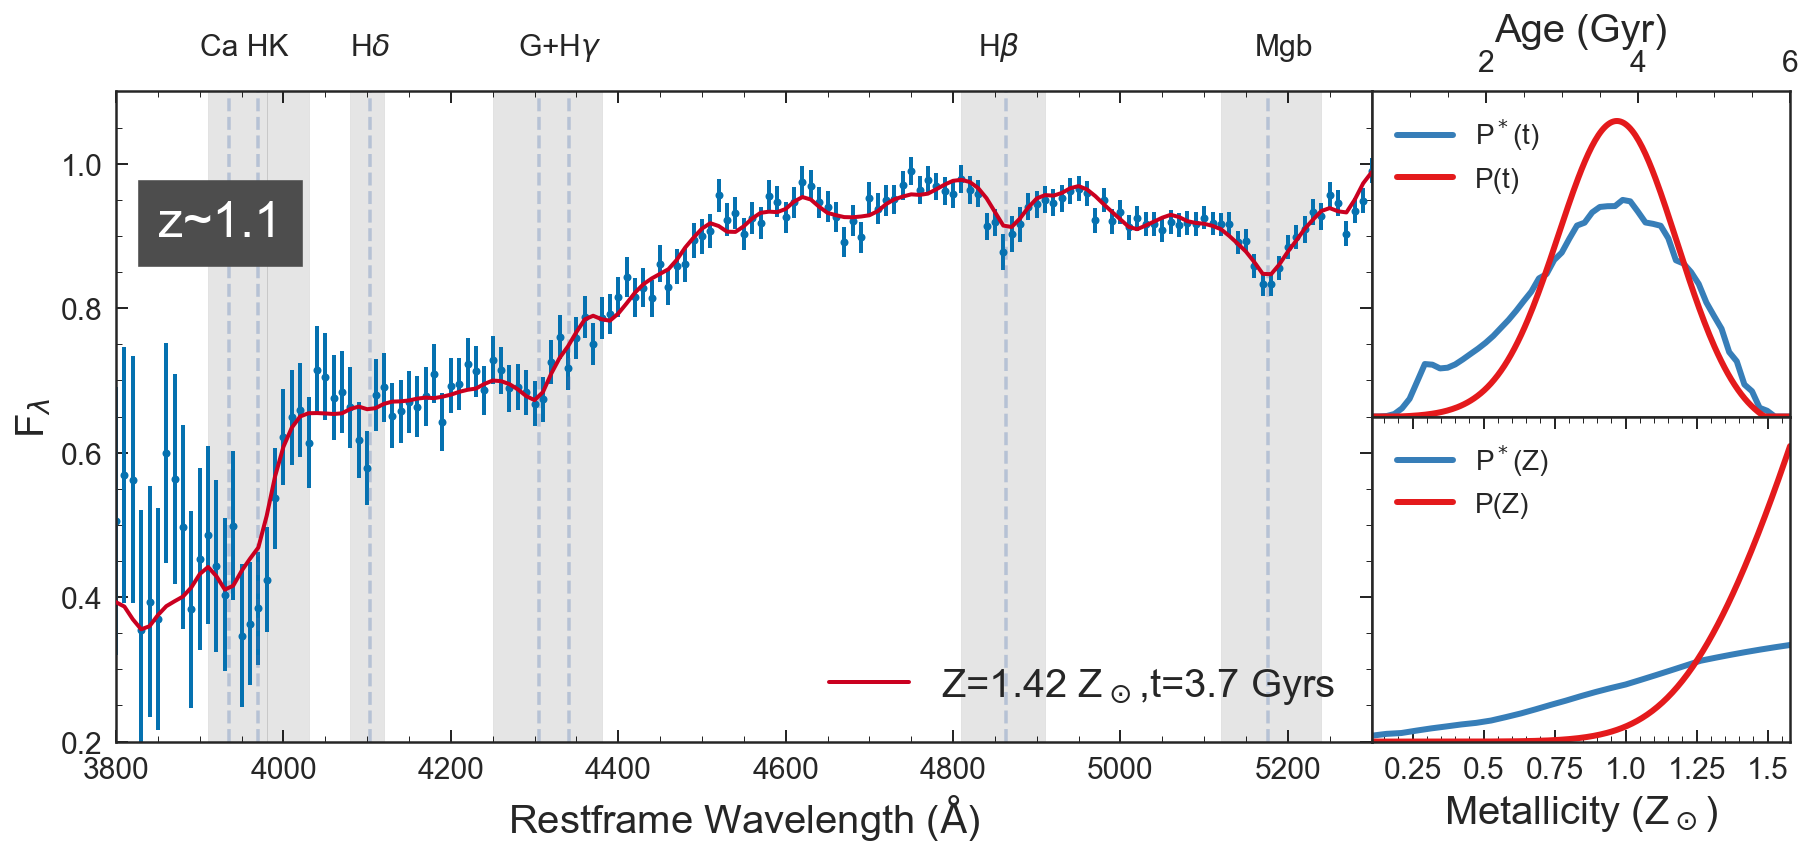

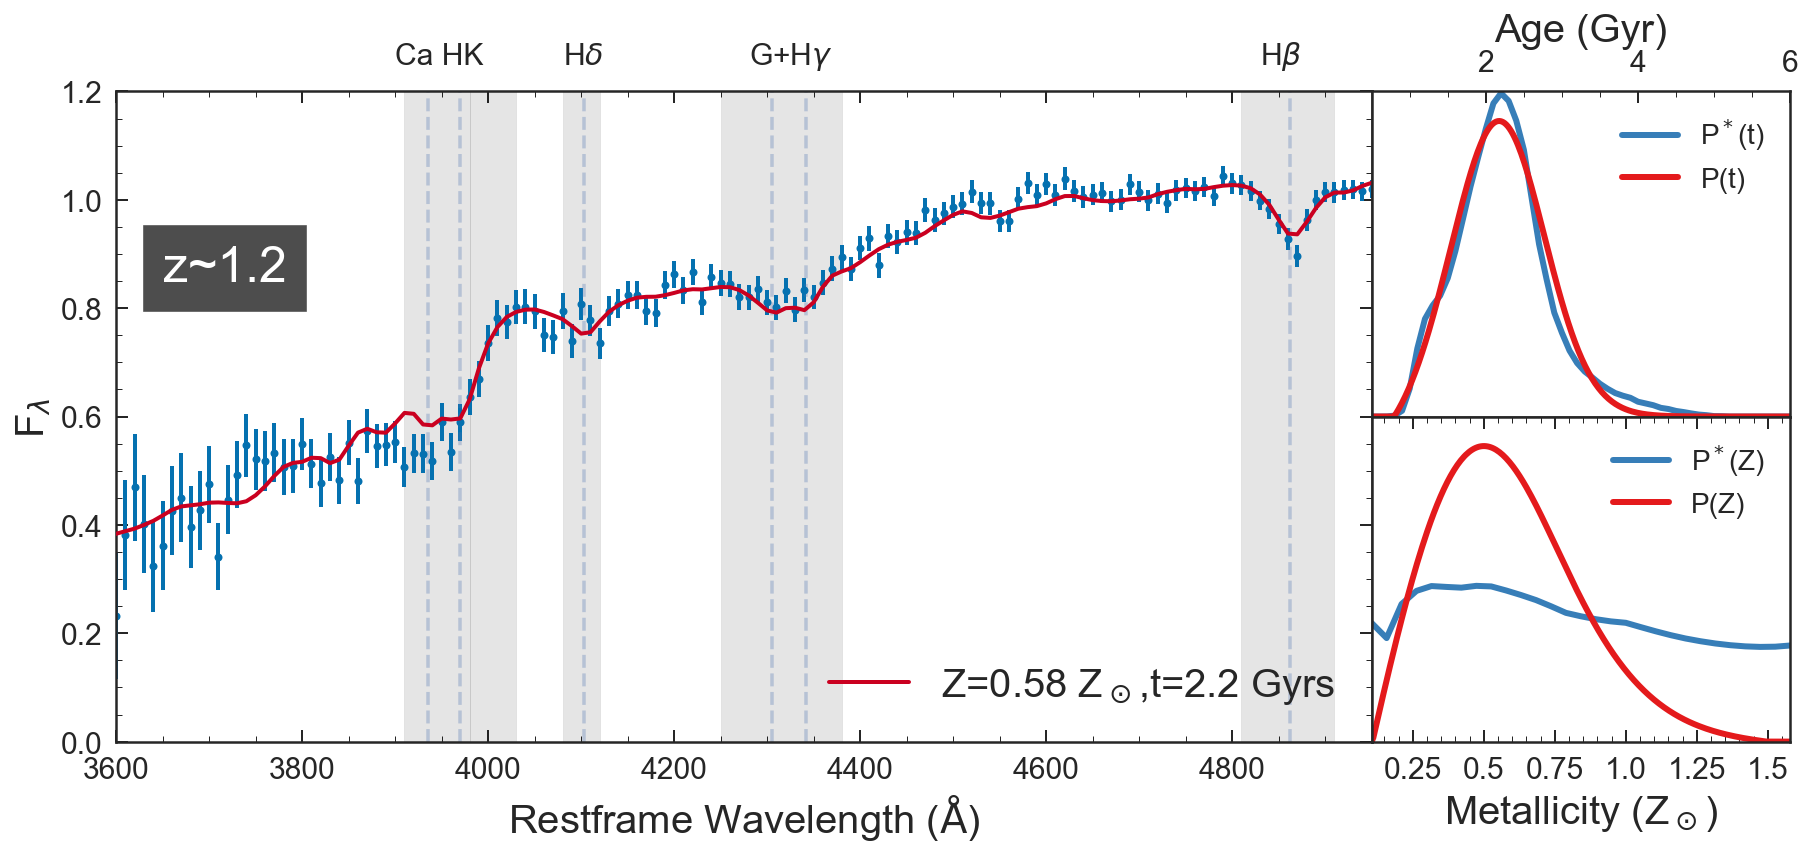

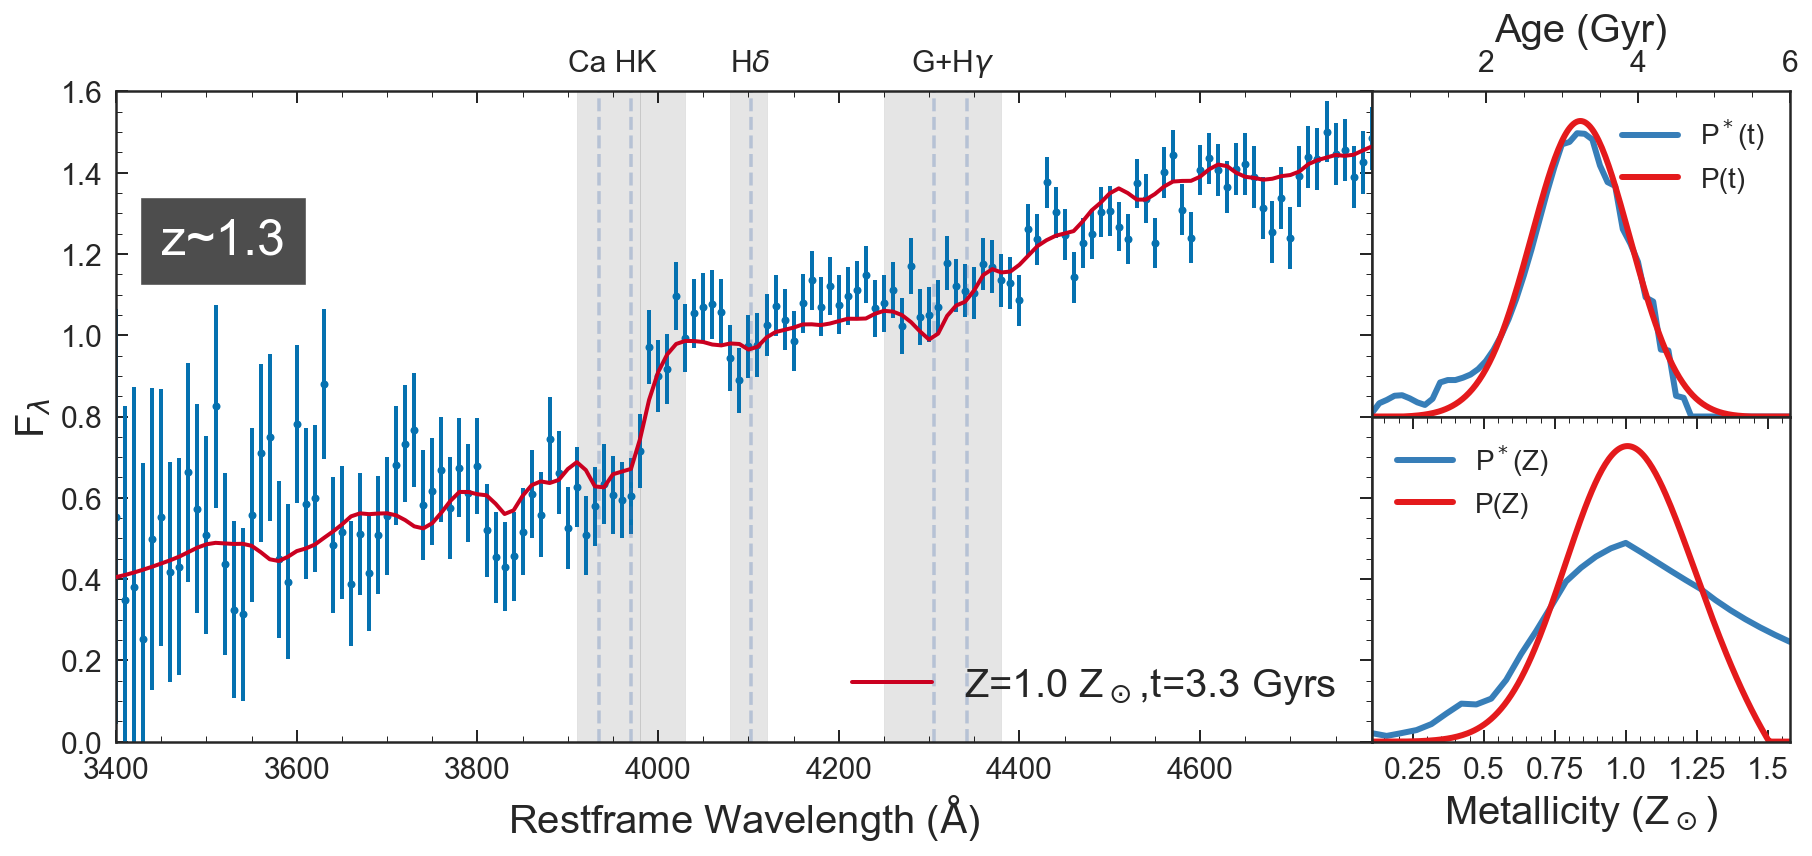

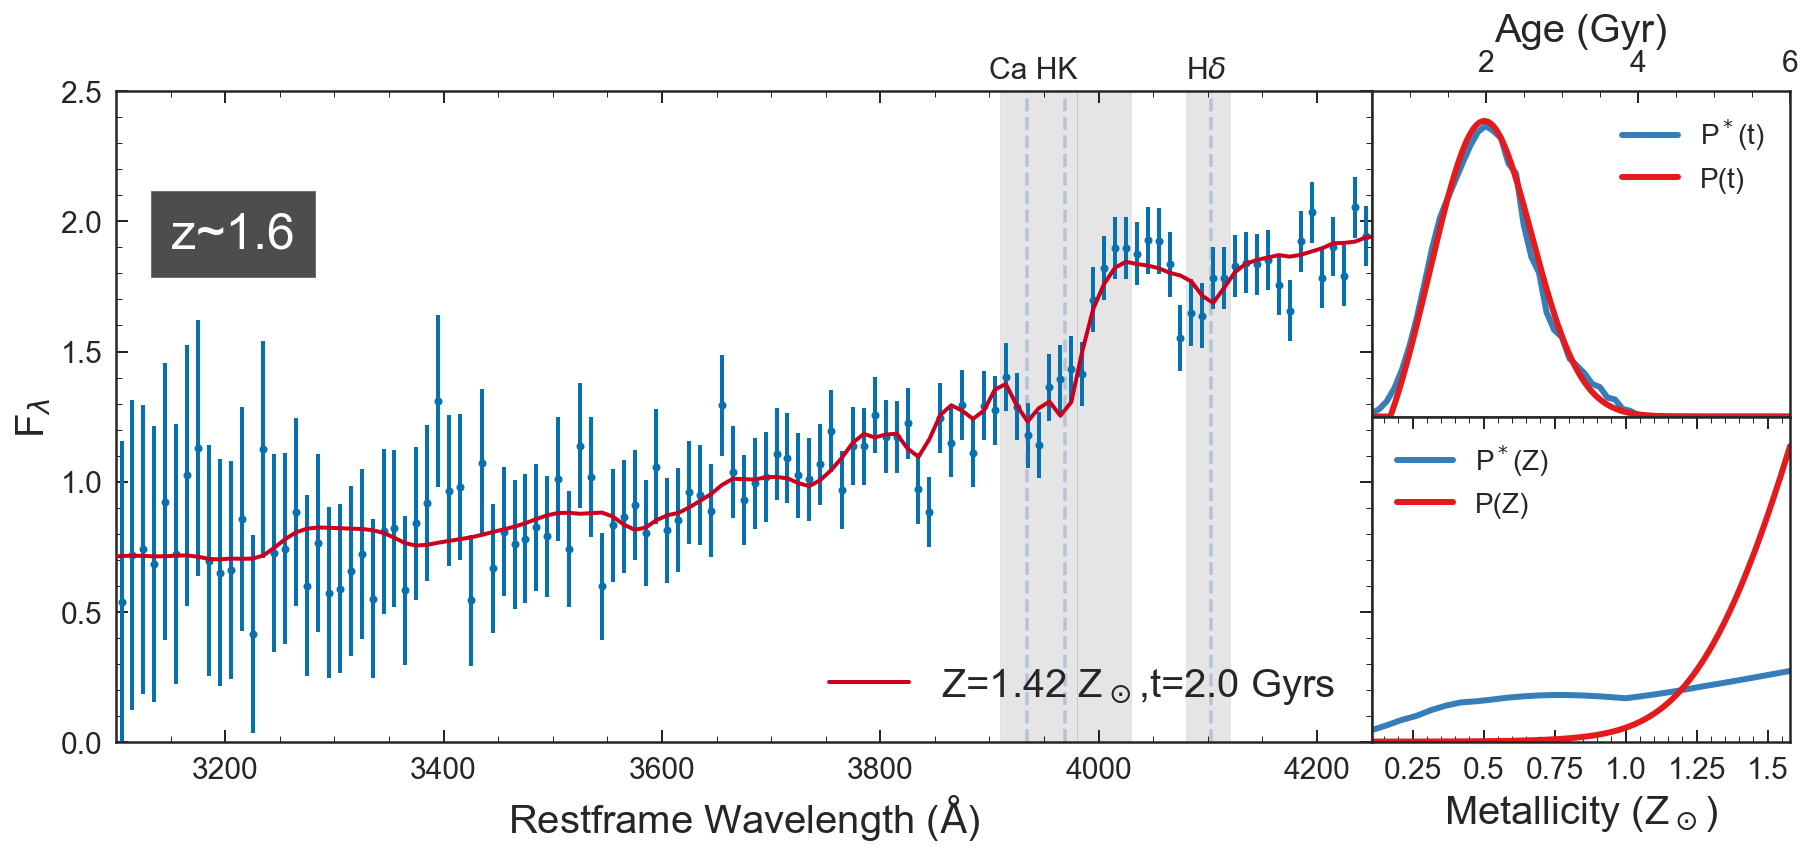

In [28]:
Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,Zmedl,tmedl,PTl,Ptx,PZl,PZx,wPTl,wPZl,
           window=[3800,5300,.2,1.1],group='z~1.1',group_win=[3850,0.9],save_plot=False,
           plot_name='../plots/stack_lz_bf_2-8.pdf')

Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,Zmedm,tmedm,PTm,Ptx,PZm,PZx,wPTm,wPZm,
           window=[3600,4950,0,1.2],group='z~1.2',group_win=[3650,0.85],save_plot=False,
           plot_name='../plots/stack_mz_bf_2-8.pdf')

Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,Zmedh,tmedh,PTh,Ptx,PZh,PZx,wPTh,wPZh,
           window=[3400,4790,0,1.6],group='z~1.3',group_win=[3450,1.2],save_plot=False,
           plot_name='../plots/stack_hz_bf_2-8.pdf')

Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,Zmeduh,tmeduh,PTuh,Ptx,PZuh,PZx,wPTuh,wPZuh,
           window=[3100,4250,0.,2.5],group='z~1.6',group_win=[3150,1.9],save_plot=False,
            plot_name='../plots/stack_uhz_bf_6-11.pdf')